# SHAP

In [2]:
#%pip install scikit-learn==1.3.2
#%pip install seaborn==0.13.1
#%pip install numpy==1.26.4
#%pip install matplotlib==3.7.1
#%pip install pandas==2.1.4
#%pip install lightgbm==4.4.0
#pip install optuna==3.6.1

   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
   ---------------------------------------- 1.4/1.4 MB 10.8 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit, StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer

import lightgbm as lgb
import shap

c:\Users\Federico\AppData\Local\Programs\Python\Python312\Lib\site-packages\dask\dataframe\__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)
c:\Users\Federico\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
base_path = 'C:/Users/Federico/Desktop/Maestria Data mining/DM EyF/'
dataset_path = base_path + 'datasets/'
modelos_path = base_path + 'modelos/'
db_path = base_path + 'db/'
dataset_file = 'competencia_01.csv'
data = pd.read_csv(dataset_path + dataset_file)

# agregue sus semillas
semillas = [540079, 250829, 314299, 302111, 801007]


In [13]:
df=data.copy()
df.shape


(981946, 155)

In [14]:
df = df.loc[df['foto_mes'] == 202104, :]

In [15]:
# Función para preparar los datos
def prepare_data(df):
    #df = df.loc[df['foto_mes'] == 202104, :]
    df.drop("foto_mes", axis=1,inplace=True)
    y = df["clase_ternaria"].map(lambda x: 0 if x == "CONTINUA" else 1)
    X = df.drop("clase_ternaria", axis=1)
    return X, y

# Función para realizar muestreo
def sample_data(X, y, sample_size=2000, seed=semillas[0]):
    np.random.seed(seed)
    
    # Seleccionar todos los índices de la clase minoritaria (los que se dan de baja)
    bajas = y[y == 1].index  # Índices de clase 1
    
    # Asegurar que `sample_size` se refiere solo a los de la clase 0
    continua_sample = y[y == 0].sample(n=sample_size, random_state=seed).index  # Muestra aleatoria de clase 0
    
    # Unión de los índices: todos los de clase 1 + muestra de clase 0
    lgb_index = continua_sample.union(bajas)
    
    # Filtra X e y usando los índices seleccionados
    X_sample = X.loc[lgb_index]
    y_sample = y.loc[lgb_index]

    return X_sample, y_sample

# Modelo sencillo 
def train_lgbm(X_sample, y_sample, num_leaves=20, learning_rate=0.05, n_estimators=100, random_state=semillas[0]):


    model = lgb.LGBMClassifier(
        num_leaves=num_leaves,
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        random_state=random_state
    )

    # Entrenar el modelo
    model.fit(X_sample, y_sample)

    return model

In [16]:
Xtrain, ytrain = prepare_data(df)
X_sample, y_sample = sample_data(Xtrain, ytrain)
model_shap =train_lgbm(X_sample, y_sample, num_leaves=30, learning_rate=0.05, n_estimators=100, random_state=semillas[0])

[LightGBM] [Info] Number of positive: 2171, number of negative: 2000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004540 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12516
[LightGBM] [Info] Number of data points in the train set: 4171, number of used features: 140
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.520499 -> initscore=0.082041
[LightGBM] [Info] Start training from score 0.082041


In [17]:
# Get shap values
explainer = shap.Explainer(model_shap)

In [18]:
shap_values = explainer(Xtrain)

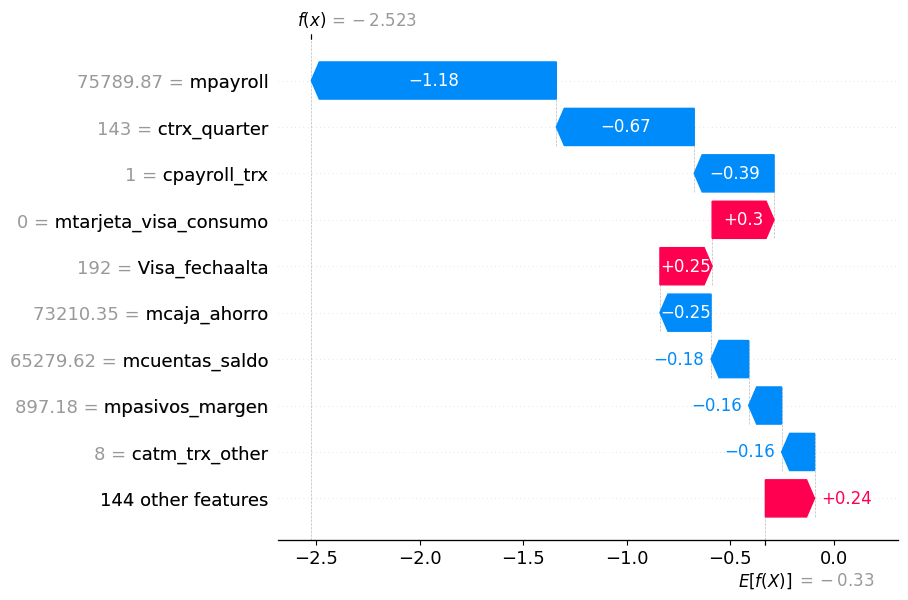

In [9]:
shap.plots.waterfall(shap_values[3], max_display=10)

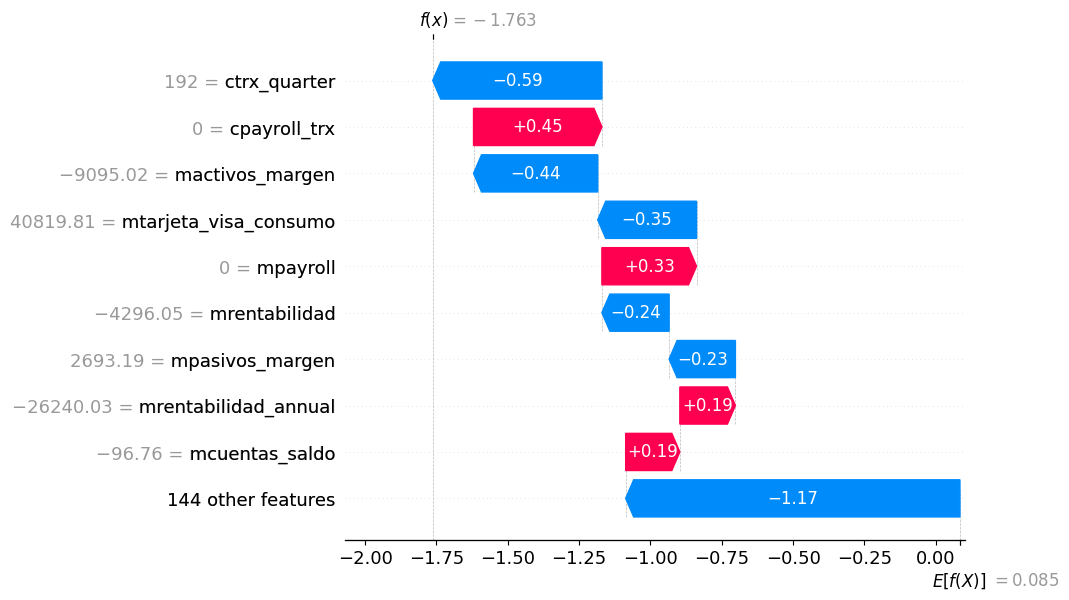

In [23]:
# Waterfall plot for first observation
shap.plots.waterfall(shap_values[0])

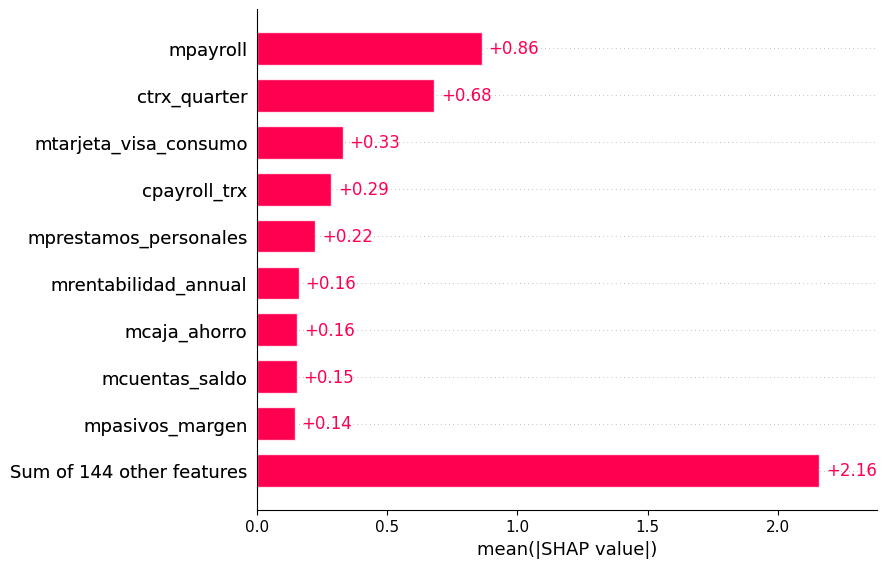

In [10]:
# Absolute Mean SHAP
shap.plots.bar(shap_values)

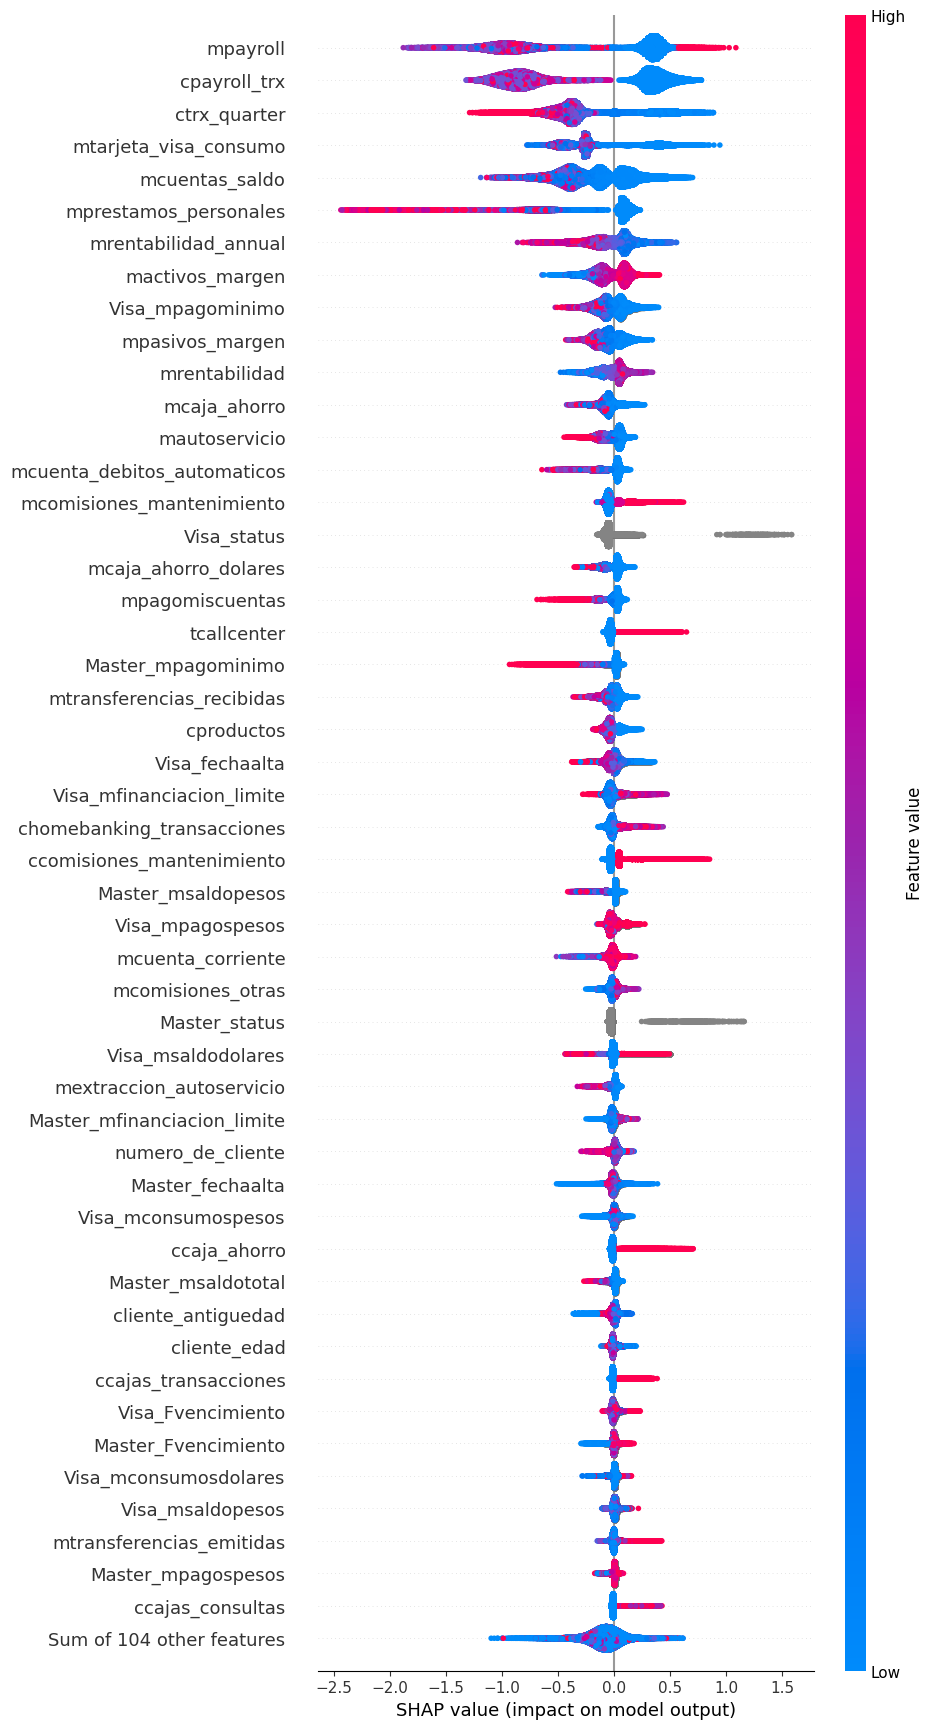

In [19]:
# Beeswarm plot
shap.plots.beeswarm(shap_values, max_display=50)

In [48]:
# Stacked force plot for first 100 observations
shap.initjs()
shap.plots.force(shap_values[0:100])

